In [93]:
import preprocessing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
import sqlite3
import seaborn as sns
import graphviz 
import matplotlib.pyplot as plt

In [2]:
filePath="./data/financial.db"
# dataframe = preprocessing.loadAllData(filePath)

In [115]:
def extractXYValues(df, yVectorName):
    notNanDF = df[ df[yVectorName].notna() ]
    yValues = notNanDF[yVectorName]
    xValues = notNanDF.loc[:, notNanDF.columns != yVectorName] 

    one_hot_Xdata = pd.get_dummies(xValues)

    return (one_hot_Xdata, yValues)

def getTrainTestSplit(xValues, yValues): 
    X_train, X_test, y_train, y_test = train_test_split(xValues, yValues, test_size=0.30)

    return (X_train, X_test, y_train, y_test)

def accChangeToDemo(filepath):
    """
        Creates column to be added to demographic table. Column is taken from the 
        summed difference of the median account balances by district (1994-1998)
        relative to the median account value in all data in 1994.
    Args:
        filepath (str): path to financial.db.
    """
    conn = sqlite3.connect(filepath)
    accdist = pd.read_sql_query("SELECT account_id, district_id from account", conn)
    df = pd.read_sql_query("SELECT date as 'y-m-d', balance, account_id from trans ", conn)
    from datetime import date
    df['y-m-d'] = pd.to_datetime(df['y-m-d'])
    df['year'] = df['y-m-d'].map(lambda x: x.strftime('%Y'))
    df = pd.merge(accdist, df, on='account_id')
    
    # Gets the average value of each account per id per district per year
    acctMedianPerAcctPerYearPerDistrict = df.groupby(['year', 'district_id', 'account_id'])[['balance']].median()

    # Calculates median/average account balance of each district per year
    medianAcct = acctMedianPerAcctPerYearPerDistrict.groupby(['year', 'district_id'])[['balance']].median()
    avgAcct = acctMedianPerAcctPerYearPerDistrict.groupby(['year', 'district_id'])[['balance']].mean()
    
    
    # Gets difference of each account's median per year
#     districtchange = average.groupby(['district_id'])[['balance']].diff().fillna(0)
#     asum = districtchange.groupby(['district_id'])[['balance']].sum()
#     newdemo = asum.div(302.70801242)

    return (acctMedianPerAcctPerYearPerDistrict.reset_index(), medianAcct.reset_index(), avgAcct.reset_index()) 

def categorizeGrowth(growthRate): 
    if growthRate > 10: 
        return 0
    elif growthRate >= 0: 
        return 1
    elif growthRate >= -10:
        return 2
    else: 
        return 3


def doKfoldCrossValidation(X,y, model, isRegression):     
    kf = KFold(n_splits=5, random_state=None, shuffle=True)
    errorRates = []
    for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
        X_train, X_test = X[train_index, :], X[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        mlModel = model()
        mlModel.fit(X_train, y_train)
        y_test_pred = mlModel.score(X_test, y_test)
        # Save off y_test_pred in a list or something -- you can average it all when done
        
#         if isRegression: 
#             errorRates.append( np.mean(np.abs(y_test.reshape((len(y_test),)) - y_test_pred) ))
#         else: 
#             errorRates.append( np.sum(y_test.reshape((len(y_test),)) == y_test_pred)/len(y_test_pred) )
        errorRates.append(y_test_pred)

    return np.mean(errorRates)


def getDataFrame(filePath): 
    (acctMedianPerAcctPerYearPerDistrict, medianPerDistrictDF, averagePerDistrictDF) = accChangeToDemo(filePath)
    conn = sqlite3.connect(filePath)
    districtDFNoNames = pd.read_sql_query("SELECT * from district", conn)
    districtDFNoNames.at[68,'A12'] = districtDFNoNames.at[68,'A13'] 
    districtDFNoNames.at[68,'A15'] = districtDFNoNames.at[68,'A16']
    
    conn.close()
    districtDF = updateColumnNames(districtDFNoNames)
    districtDF.drop(['districtName', 'region'], axis=1, inplace=True)
    
    dfAccts = districtDF.merge(acctMedianPerAcctPerYearPerDistrict, on=["district_id"])
    medianPerDistAccts = districtDF.merge(medianPerDistrictDF, on=["district_id"])
    meanPerDistAccts =  districtDF.merge(averagePerDistrictDF, on=["district_id"])

    return (dfAccts,medianPerDistAccts,meanPerDistAccts)

def getAccuracy(X,y, model, isRegression): 
    xTrain, xTest, yTrain, yTest = getTrainTestSplit(X,y)
    modelObject = model()
    modelObject.fit(xTrain, yTrain)
    yPredicted = modelObject.predict(xTest)
    
    if isRegression: 
        return (modelObject, metrics.r2_score(yTest, yPredicted))
    else:
        return (modelObject, metrics.accuracy_score(yTest,yPredicted))


def applyModelToDataframe(df, xColumnsArray, yVectorName, model, isRegression, classifierType='linear'): 

    X = df[xColumnsArray].values
    y = df[yVectorName].values.reshape((len(df[yVectorName],)))

    kFoldAccuracy = doKfoldCrossValidation(X,y, model, isRegression)
    (modelObject, accuracy) = getAccuracy(X,y, model, isRegression)
    
    if classifierType=='randomForest':
        printImportance(modelObject, X)
    elif classifierType == 'decisionTree': 
        plt.figure(figsize=(15,15)) 
        plot_tree(modelObject, fontsize=12)
        plt.show()
    
    return (kFoldAccuracy, accuracy)

def updateColumnNames(df): 
    columnNames = ['district_id','districtName','region', 'numInhabitants', 
                   'municipalitiesLess500','municipalities500to2k','municipalities2kto10k',
                   'municipalitiesGreater10k','numCities','ratioUrbanInhabitants','avgSalary',
                   'unEmployment95','unEmployment96','entrepeneursPer1k','crimesIn95','crimesIn96' ] 
    df.columns = columnNames
        
    return df

def printImportance(model, X): 
    importances = model.feature_importances_
    std = np.std([model.feature_importances_ for tree in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the impurity-based feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
            color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()

In [45]:
dfAcct, medianPerDistrict, meanPerDistrict = getDataFrame(filePath)
allXColumns = ['district_id','numInhabitants', 'municipalitiesLess500','municipalities500to2k','municipalities2kto10k','municipalitiesGreater10k','numCities',                   
           'ratioUrbanInhabitants','avgSalary','unEmployment95','unEmployment96', 'entrepeneursPer1k', 'crimesIn95', 'crimesIn96' ] 
yVector = ['balance']

Feature ranking:
1. feature 10 (0.109197)
2. feature 11 (0.096203)
3. feature 0 (0.089386)
4. feature 7 (0.085927)
5. feature 2 (0.085247)
6. feature 1 (0.082521)
7. feature 8 (0.075721)
8. feature 9 (0.073896)
9. feature 12 (0.062478)
10. feature 4 (0.059366)
11. feature 3 (0.055739)
12. feature 6 (0.055043)
13. feature 13 (0.051532)
14. feature 5 (0.017745)


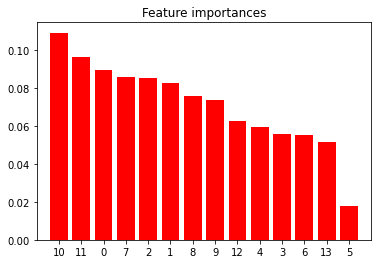

(0.0017845905450485145, 0.0024738937022895646)

In [46]:
randomForestAccuracy = applyModelToDataframe(dfAcct, allXColumns, yVector, RandomForestRegressor, True, 'randomForest')
randomForestAccuracy

In [47]:
linearRegressionAccuracy = applyModelToDataframe(dfAcct, allXColumns, yVector, LinearRegression, True)
linearRegressionAccuracy

(-0.0005927429870852041, -0.0015052360842500168)

In [48]:
balanceRatioSalary = ['balance'] 
yVector = ['district_id']

In [49]:
randomForestClassificationDfAcct = applyModelToDataframe(dfAcct, balanceRatioSalary, yVector, RandomForestClassifier, False )
randomForestClassificationMedian = applyModelToDataframe(medianPerDistrict, balanceRatioSalary, yVector, RandomForestClassifier, False  )
randomForestClassificationMean = applyModelToDataframe(meanPerDistrict, balanceRatioSalary, yVector, RandomForestClassifier, False  )

In [50]:
print(f"""
randomForestClassificationDfAcct {randomForestClassificationDfAcct}
randomForestClassificationMedian {randomForestClassificationMedian}
randomForestClassificationMean {randomForestClassificationMean}
""")


randomForestClassificationDfAcct (0.030491264221671744, 0.031914893617021274)
randomForestClassificationMedian (0.015170640486208508, 0.0)
randomForestClassificationMean (0.004347826086956522, 0.014388489208633094)



In [51]:
someData = preprocessing.loadAllData(filePath, True)

In [52]:
loanDF = someData[someData['status'].notna()].drop(['card_id', 'type_y', 'issued', 'date_y', 'date_x', 'issued', 'type_y', 'issued'], axis=1)
loanDF[loanDF['district_id' ]==15]

,account_id,district_id,frequency,disp_id,client_id,type_x,gender,birth_date,district_id_y,loan_id,...,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
856,314,15,2,383,383,0,0,-9.665424e+08,15,5039.0,...,7,1,5,51.9,9045,3.1,3.6,124,1845.0,1879
857,314,15,2,384,384,1,1,-1.080328e+09,15,5039.0,...,7,1,5,51.9,9045,3.1,3.6,124,1845.0,1879
906,4825,15,0,5826,5826,0,1,-4.137120e+07,15,5980.0,...,7,1,5,51.9,9045,3.1,3.6,124,1845.0,1879
907,4825,15,0,5827,5827,1,0,1.601172e+08,15,5980.0,...,7,1,5,51.9,9045,3.1,3.6,124,1845.0,1879
908,5283,15,0,6383,6383,0,1,5.364000e+05,15,6078.0,...,7,1,5,51.9,9045,3.1,3.6,124,1845.0,1879
910,5572,15,0,6729,6729,0,1,-3.791052e+08,15,6136.0,...,7,1,5,51.9,9045,3.1,3.6,124,1845.0,1879
911,5593,15,0,6753,6753,0,1,-2.401776e+08,15,6144.0,...,7,1,5,51.9,9045,3.1,3.6,124,1845.0,1879
912,5927,15,0,7166,7166,0,1,-1.778832e+08,15,6210.0,...,7,1,5,51.9,9045,3.1,3.6,124,1845.0,1879
915,11265,15,0,13537,13845,0,1,9.868680e+07,15,7284.0,...,7,1,5,51.9,9045,3.1,3.6,124,1845.0,1879


In [53]:
for column in loanDF.columns: 
    if len(loanDF[loanDF[column].isna()]) > 0: 
        print(column)

In [67]:
accuracy=applyModelToDataframe(loanDF, ['account_id', 'district_id', 'frequency', 'disp_id', 'client_id',
       'type_x', 'gender', 'birth_date', 'district_id_y', 'loan_id', 'amount',
       'duration', 'payments', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8',
       'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16'], ['status'], RandomForestClassifier, False)
accuracy

(0.7448557867834976, 0.6827309236947792)

Feature ranking:
1. feature 10 (0.153401)
2. feature 9 (0.116100)
3. feature 11 (0.083162)
4. feature 7 (0.059380)
5. feature 4 (0.057329)
6. feature 0 (0.054885)
7. feature 3 (0.052937)
8. feature 8 (0.050846)
9. feature 20 (0.034576)
10. feature 13 (0.027644)
11. feature 25 (0.026856)
12. feature 23 (0.026389)
13. feature 24 (0.025025)
14. feature 19 (0.025008)
15. feature 1 (0.024801)
16. feature 21 (0.024704)
17. feature 14 (0.023688)
18. feature 15 (0.023293)
19. feature 22 (0.022216)
20. feature 16 (0.019149)
21. feature 18 (0.017275)
22. feature 17 (0.012414)
23. feature 12 (0.012348)
24. feature 2 (0.011165)
25. feature 6 (0.010877)
26. feature 5 (0.004531)


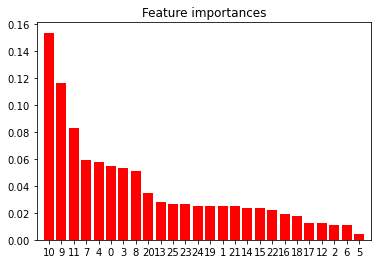

In [74]:
xCols = ['account_id', 'district_id', 'frequency', 'disp_id', 'client_id',
       'type_x', 'gender', 'birth_date', 'loan_id', 'amount',
       'duration', 'payments', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8',
       'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16']
yCol = [ 'status' ]

acc = applyModelToDataframe(loanDF, xCols, yCol, RandomForestClassifier, False, 'randomForest')

Feature ranking:
1. feature 0 (1.000000)


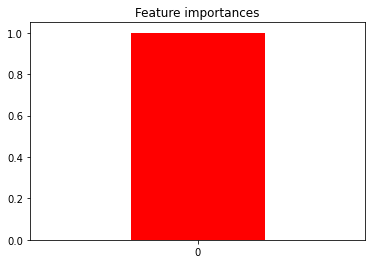

(0.7146257758305952, 0.714859437751004)

In [80]:
acc = applyModelToDataframe(loanDF, ['duration'], yCol, RandomForestClassifier, False, 'randomForest')
acc

In [75]:
X = np.array(xCols)
higherAccCols = X[[10,9,11,7,0,3,8,4]]

Feature ranking:
1. feature 0 (0.172413)
2. feature 1 (0.160066)
3. feature 2 (0.150198)
4. feature 4 (0.104991)
5. feature 3 (0.104923)
6. feature 5 (0.104523)
7. feature 7 (0.103053)
8. feature 6 (0.099833)


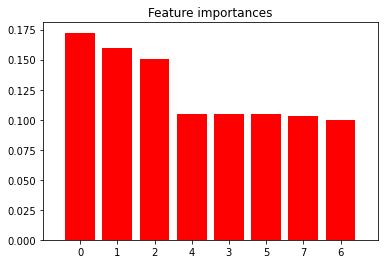

In [76]:
yCol = [ 'status' ]
acc = applyModelToDataframe(loanDF, higherAccCols, yCol, RandomForestClassifier, False, 'randomForest')

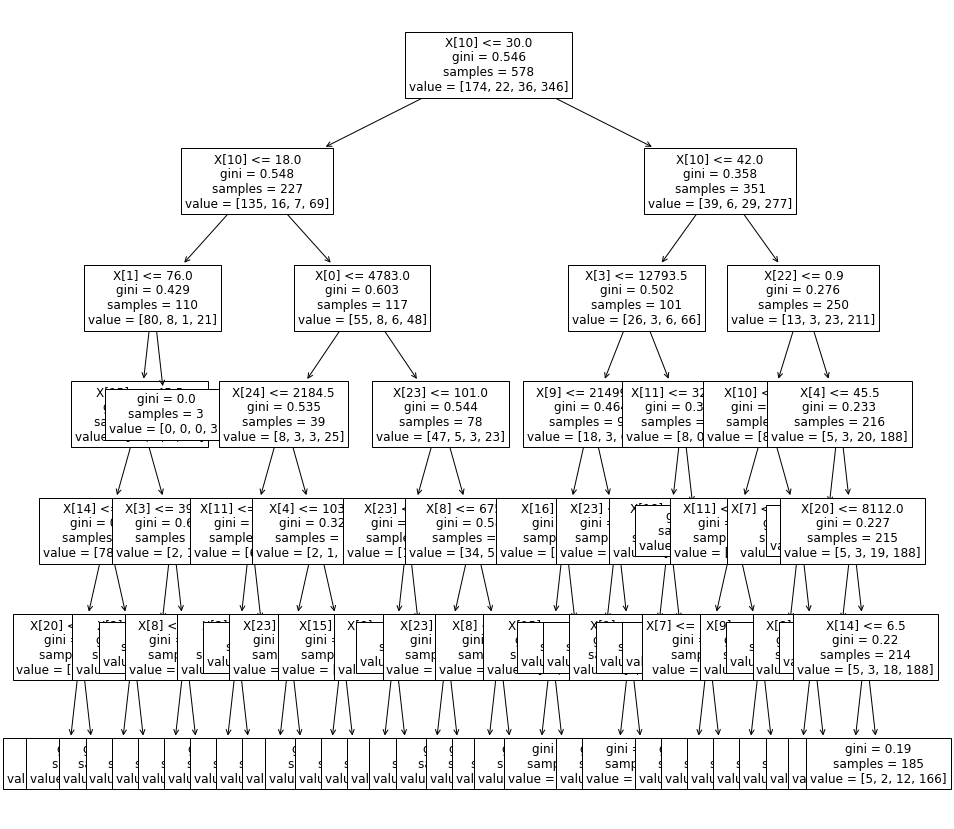

In [116]:
acc = applyModelToDataframe(loanDF, xCols, yCol, lambda: DecisionTreeClassifier(max_depth=6), False, 'decisionTree')


In [110]:
acc = applyModelToDataframe(loanDF, xCols, yCol, lambda: KNeighborsClassifier(n_neighbors=400), False)
acc

(0.5962248995983936, 0.5742971887550201)